# Suavizado señal saturación

En este notebook se muestra el preprocesado que se le puede aplicar a la señal de saturación. En particular, se muestra la eliminación de outliers de la señal, asi como el suavizado de la misma para evitar los picos.

In [1]:
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import utils
from paciente import Paciente
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#CF9962", '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) 
plt.rcParams["patch.force_edgecolor"] = True

In [2]:
def plot_dataframe_column(dfs:list, colname:str, time_step, number_samples, initial_sample=0, labels=None, savefig=True, figsize=(10, 5)):
    plt.figure(figsize=figsize)

    labels = [None]*len(dfs) if labels is None else labels

    for current_df, current_label in zip(dfs, labels):
        plt.plot(current_df[colname][:number_samples], label=current_label)

    title = f"Evolución variable {colname}"
    plt.title(title)
    
    number_ticks = 10
    xticks_step = int(number_samples/number_ticks)
    x_ticks_pos = list(range(0, number_samples))[::xticks_step]
    x_ticks_label = [round(i*time_step) for i in x_ticks_pos]

    plt.xticks(x_ticks_pos, x_ticks_label)
    if labels[0] is not None:
        plt.legend()

    plt.xlabel("segundos (s)")
    plt.ylabel(f"Nivel {colname}")
    if savefig: plt.savefig(f"{title.replace(' ', '_').lower()}.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)

In [3]:
def find_first_outlier(df, max_deviations=5, column = "spo2"):
    an_array = df[column]
    mean = np.mean(an_array)
    standard_deviation = np.std(an_array)
    distance_from_mean = abs(an_array - mean)
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    outliers_index = [i for i, no_outlier in enumerate(not_outlier) if no_outlier == False]
    outlier = range(outliers_index[0]-500, outliers_index[0]+500)
    return df.iloc[outlier].reset_index()

## Configuración de variables

En esta sección, se debe indicar la ruta donde se encuentra la información del paciente que se desea estudiar.

In [4]:
# Indicar la ruta donde se encuentra el fichero que se va a estudiar
nombre_fichero = "data_5.csv"

# Directorio que contiene los ficheros .csv que se van a analizar
dataset_dir = "../data/pacientes"

# Indicamos las variables que vamos a querer estudiar. Tienen que ser variables que se encuentren disponibles en el fichero csv
variables_significativas = ['SpO2']
paciente = Paciente(filename=os.path.join(dataset_dir, nombre_fichero), variables_significativas=variables_significativas)
paciente.comprobar_validez_dataset()

True

## Analisis y procesado de la serie

En primer lugar, vamos a observar la forma que tiene la serie temporal, para a continuación realizar un suavizado de la misma, con la correspondiente eliminación de outliers en esta.

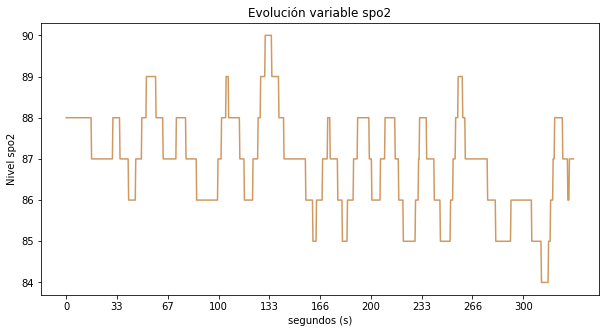

In [5]:
number_samples = 1000 # Número de muestras que queremos representar gráficamente
plot_dataframe_column(dfs=[paciente.df], colname='spo2', time_step=paciente.time_step, number_samples=number_samples, savefig=False)

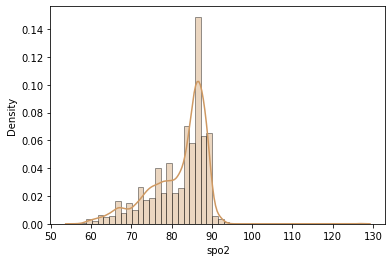

In [6]:
ax = sns.distplot(paciente.df["spo2"])
ax.grid(False)
plt.show()

In [7]:
df_outliers = find_first_outlier(paciente.df)

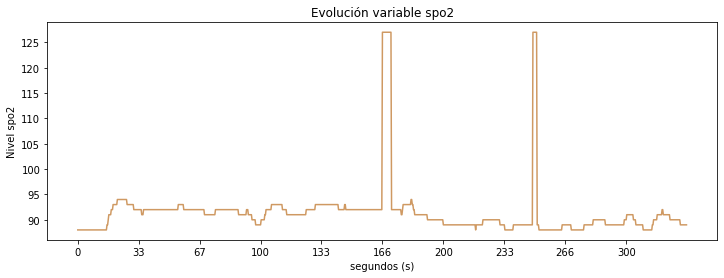

In [8]:
number_samples = 1000 # Número de muestras que queremos representar gráficamente
plot_dataframe_column(dfs=[df_outliers], colname='spo2', time_step=paciente.time_step, number_samples=number_samples, savefig=True, figsize=(12, 4))

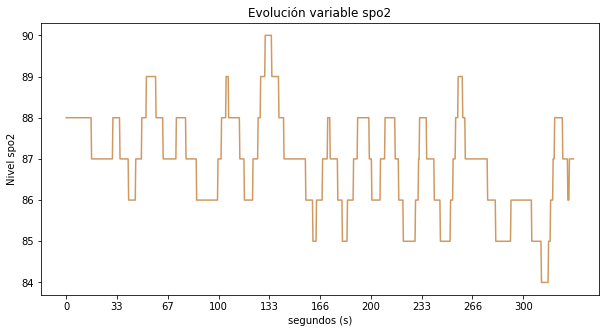

In [9]:
# Representamos gráficamente el outlier de la serie temporal
number_samples = 1000 # Número de muestras que queremos representar gráficamente
plot_dataframe_column(dfs=[paciente.df], colname='spo2', time_step=paciente.time_step, number_samples=number_samples, savefig=True)

Como podemos observar, la serie de la saturación está formada por picos, y contiene outliers que queremos eliminar. Para ello, hacemos uso de la funcionalidad smooth_data de la clase Paciente

In [10]:
paciente.suavizar_seniales(smooth_seconds=6) # Este profeso elimina los outliers, y suaviza la señal

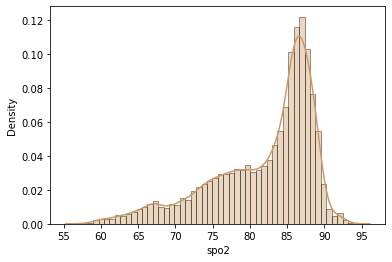

In [11]:
ax = sns.distplot(paciente.df_smothed["spo2"])
ax.grid(False)
plt.show()

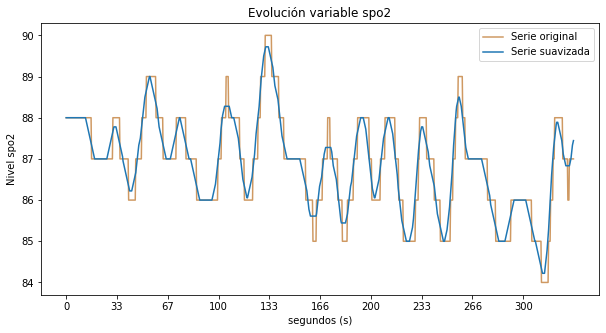

In [12]:
plot_dataframe_column(dfs=[paciente.df, paciente.df_smothed], labels=["Serie original", "Serie suavizada"], colname='spo2', time_step=paciente.time_step, number_samples=number_samples, savefig=False)

Podemos observar como la señal tiene una silueta mucho más suavizada, y como en el histograma se han eliminado los outliers de la serie.

## Comparativa escala nivel de saturación 

Es conveniente comprobar si la escala en la que se encuentran los valores de saturación es la misma para todos los pacientes, o si esta varía en función del paciente.

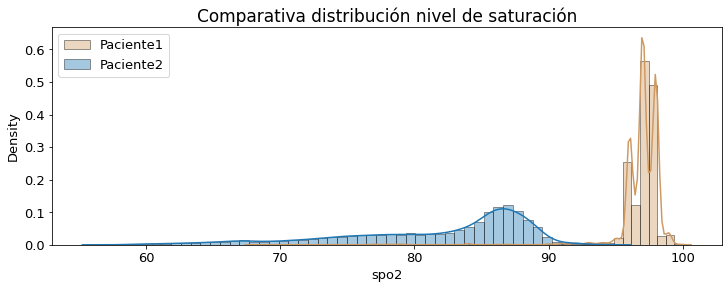

In [13]:
utils.set_font_size(plt, 13)
pacientes_histograma = ["data_9.csv", "data_5.csv"]

plt.figure(figsize=(12, 4))
ax.grid(False)

for i, p in enumerate(pacientes_histograma):
    paciente = Paciente(filename=os.path.join(dataset_dir, p), variables_significativas=variables_significativas)
    paciente.comprobar_validez_dataset()

    paciente.suavizar_seniales(smooth_seconds=6)


    ax = sns.distplot(paciente.df_smothed["spo2"], label=f"Paciente{i+1}")

    #plt.savefig("histograma_serie_suavizada.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)
plt.legend()
plt.title("Comparativa distribución nivel de saturación")
plt.show()

Como podemos observar, las escalas de los valores son diferentes para distintos pacientes